In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from datetime import datetime


In [6]:
# Load the dataset
df = pd.read_csv('user_activity_pattern_updated_v6_30_nov.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [7]:
# Create time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

# Group by time periods for aggregation
df_hourly = df.groupby(df['timestamp'].dt.floor('H')).agg({'usage_minutes': 'sum'}).reset_index()
df_daily = df.groupby(df['timestamp'].dt.date).agg({'usage_minutes': 'sum'}).reset_index()
df_weekly = df.groupby(df['timestamp'].dt.to_period('W')).agg({'usage_minutes': 'sum'}).reset_index()
df_monthly = df.groupby(df['timestamp'].dt.to_period('M')).agg({'usage_minutes': 'sum'}).reset_index()


In [8]:
# Aggregation by service group and service name
service_group_usage = df.groupby('service_group')['usage_minutes'].sum().reset_index()
service_name_usage = df.groupby('service_name')['usage_minutes'].sum().reset_index()


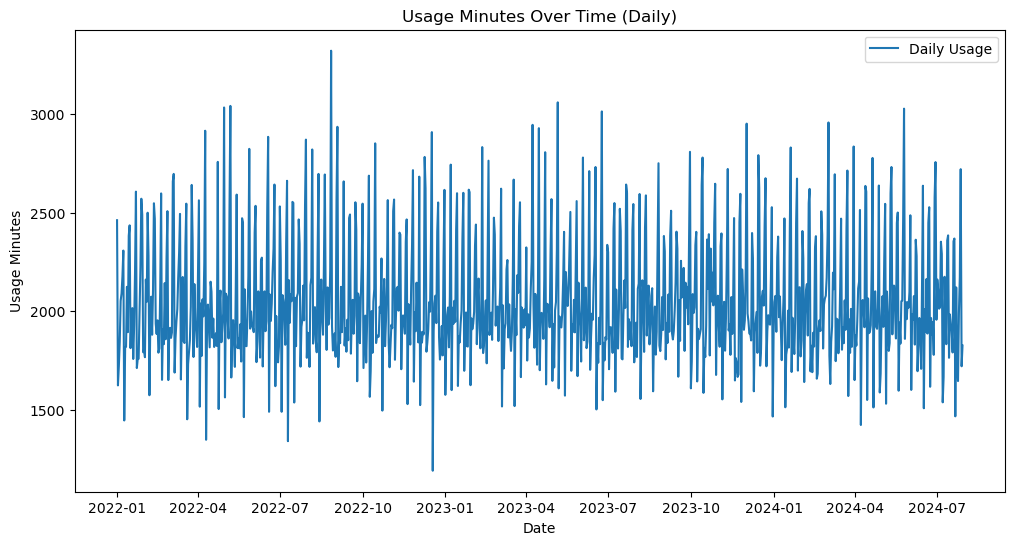

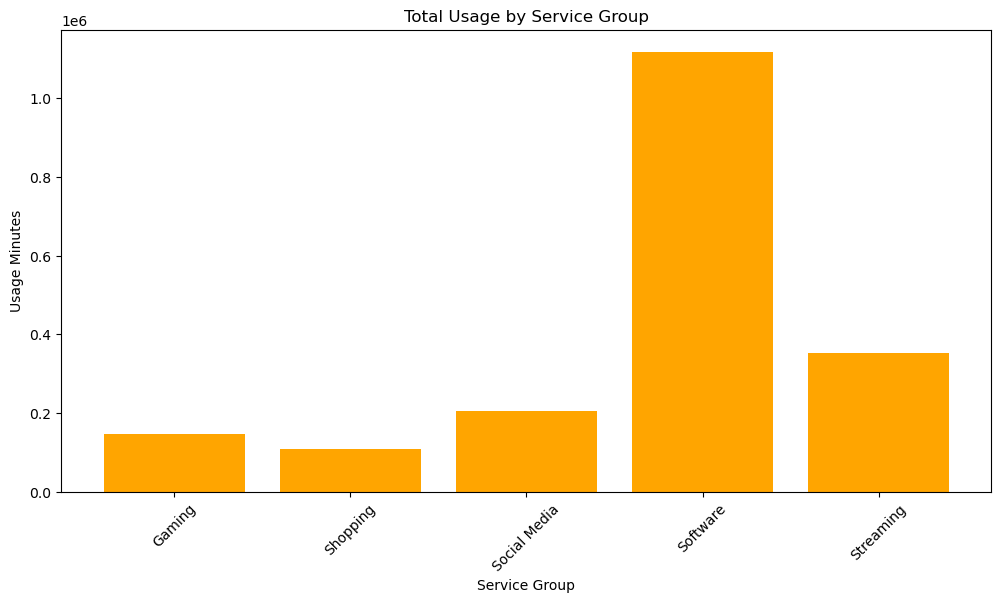

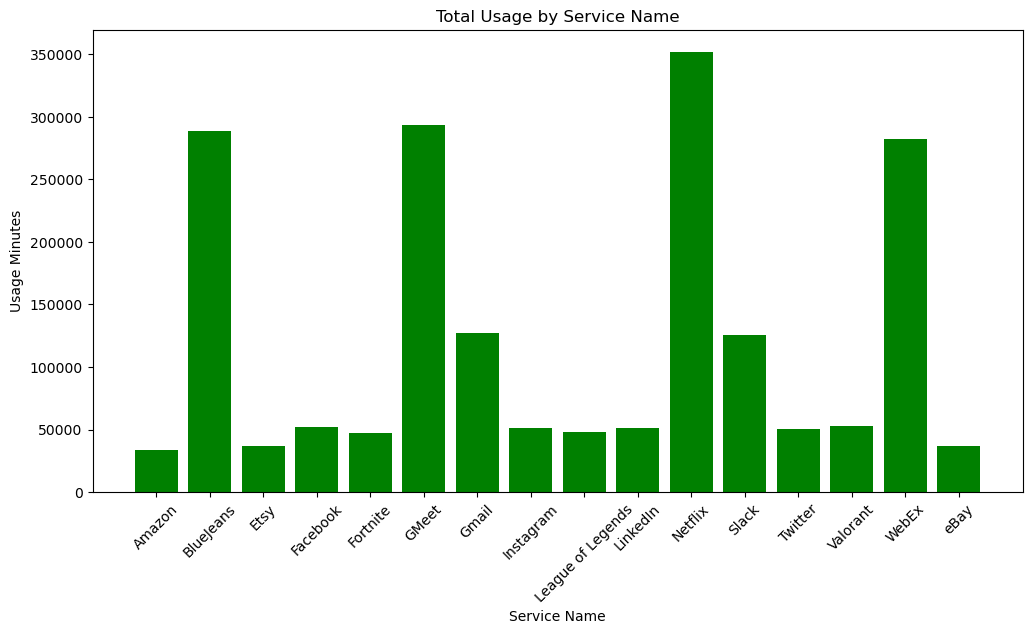

In [9]:
# Daily Usage Trend
plt.figure(figsize=(12, 6))
plt.plot(df_daily['timestamp'], df_daily['usage_minutes'], label='Daily Usage')
plt.title('Usage Minutes Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Usage Minutes')
plt.legend()
plt.show()

# Usage by Service Group
plt.figure(figsize=(12, 6))
plt.bar(service_group_usage['service_group'], service_group_usage['usage_minutes'], color='orange')
plt.title('Total Usage by Service Group')
plt.xlabel('Service Group')
plt.ylabel('Usage Minutes')
plt.xticks(rotation=45)
plt.show()

# Usage by Service Name
plt.figure(figsize=(12, 6))
plt.bar(service_name_usage['service_name'], service_name_usage['usage_minutes'], color='green')
plt.title('Total Usage by Service Name')
plt.xlabel('Service Name')
plt.ylabel('Usage Minutes')
plt.xticks(rotation=45)
plt.show()


In [10]:
# Normalize numerical features
scaler = MinMaxScaler()
df[['normalized_usage_minutes']] = scaler.fit_transform(df[['usage_minutes']])

# Select features for the model
features = ['normalized_usage_minutes', 'hour', 'weekday', 'month']
target = 'normalized_usage_minutes'


In [11]:
# Prepare data for GRU
sequence_length = 30
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df[features].iloc[i:i + sequence_length].values)
    y.append(df[target].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], len(features))  # Reshape for GRU model


2024-12-02 16:39:58.229135: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-02 16:39:58.229154: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-02 16:39:58.229173: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-02 16:39:58.229269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-02 16:39:58.229296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2024-12-02 16:39:59.062709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 47ms/step - loss: 0.1413 - val_loss: 0.1053
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.1212 - val_loss: 0.0889
Epoch 3/5
10/10 [==============================] - 0s 13ms/step - loss: 0.1083 - val_loss: 0.0976
Epoch 4/5
10/10 [==============================] - 0s 14ms/step - loss: 0.0989 - val_loss: 0.0902
Epoch 5/5
10/10 [==============================] - 0s 12ms/step - loss: 0.1005 - val_loss: 0.0915


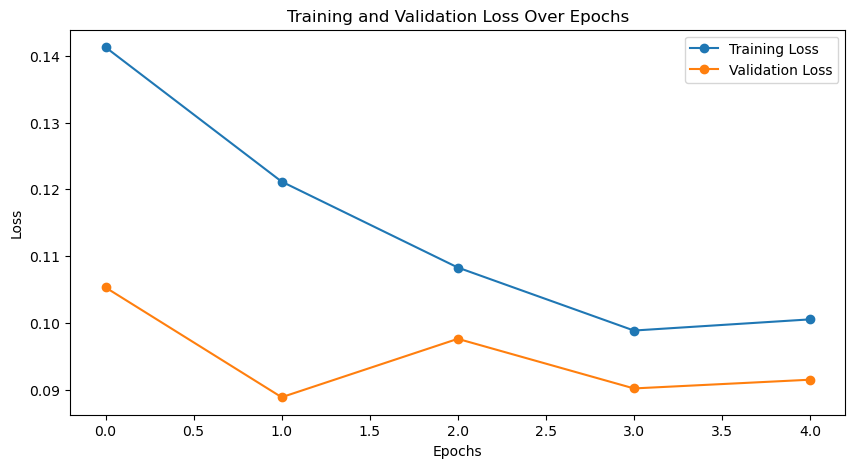

In [12]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Example: Sequence length and feature count for input data
sequence_length = 30  # Length of the time series sequence
features = ['normalized_usage_minutes', 'hour', 'weekday', 'month']  # Example features

# Build Optimized GRU Model
model = Sequential([
    GRU(32, return_sequences=True, input_shape=(sequence_length, len(features))),  # Reduce units from 50 to 32
    GRU(16),  # Reduce units from 50 to 16 in the second layer
    Dense(1)  # Output layer remains the same
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Example data for training
# Replace `X` and `y` with your actual training data
X = np.random.rand(100, sequence_length, len(features))  # Example random data
y = np.random.rand(100)  # Example random target

# Train the model
history = model.fit(
    X, y,
    epochs=5,                # Reduce epochs to 5
    batch_size=8,            # Reduce batch size to 8
    validation_split=0.2,    # Reserve 20% of data for validation
    verbose=1                # Display training progress
)

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
#Learning Rate Adjustment: Slightly reducing the learning rate can stabilize the model and improve convergence in later epochs:

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [14]:
## L2 Regularization: Add L2 weight regularization to the GRU layers to prevent overfitting:


In [15]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    GRU(32, return_sequences=True, input_shape=(sequence_length, len(features)),
        kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    GRU(16, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)
])


Epoch 1/20


2024-12-02 16:40:06.863158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


10/10 [==============================] - 1s 54ms/step - loss: 0.6992 - val_loss: 0.5512
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 0.5253 - val_loss: 0.4870
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 0.4962 - val_loss: 0.4535
Epoch 4/20
10/10 [==============================] - 0s 21ms/step - loss: 0.4557 - val_loss: 0.4299
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 0.4247 - val_loss: 0.4096
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 0.3908 - val_loss: 0.3726
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 0.3718 - val_loss: 0.3507
Epoch 8/20
10/10 [==============================] - 0s 24ms/step - loss: 0.3442 - val_loss: 0.3356
Epoch 9/20
10/10 [==============================] - 0s 19ms/step - loss: 0.3209 - val_loss: 0.3127
Epoch 10/20
10/10 [==============================] - 0s 19ms/step - loss: 0.3070 - val_loss: 0.2970
Epoch 11/20
10/10 [=

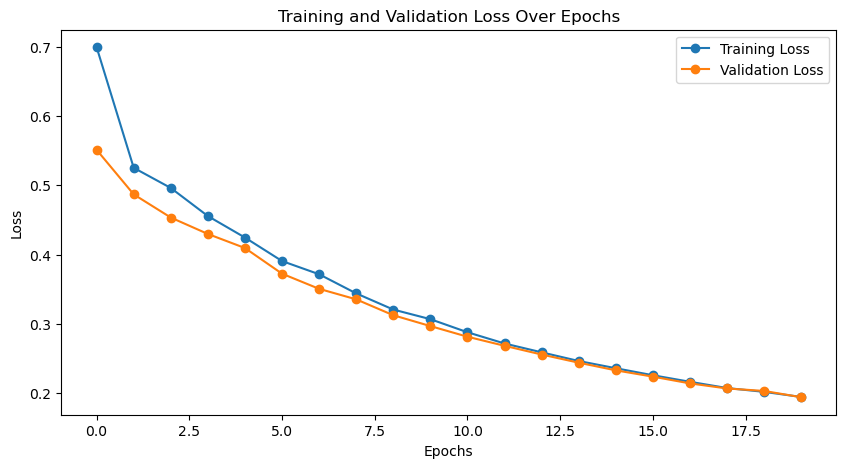

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Build Optimized Model
model = Sequential([
    GRU(32, return_sequences=True, input_shape=(sequence_length, len(features)),
        kernel_regularizer=l2(0.01)),  # Add L2 regularization
    Dropout(0.2),  # Dropout to prevent overfitting
    GRU(16, kernel_regularizer=l2(0.01)),  # Add L2 regularization
    Dropout(0.2),
    Dense(1)
])

# Compile with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X, y,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualize Training and Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
## Train test split

from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
df_train = df[:train_size]
df_test = df[train_size:]

# Prepare training data
X_train, y_train = [], []
for i in range(len(df_train) - sequence_length):
    X_train.append(df_train[features].iloc[i:i + sequence_length].values)
    y_train.append(df_train[target].iloc[i + sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))  # Reshape for GRU model

# Prepare test data
X_test, y_test = [], []
for i in range(len(df_test) - sequence_length):
    X_test.append(df_test[features].iloc[i:i + sequence_length].values)
    y_test.append(df_test[target].iloc[i + sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))  # Reshape for GRU model


In [18]:
## Evaluate the Model : evaluate the model on the test set:

In [19]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")


285/285 [==============================] - 3s 10ms/step - loss: 0.2372
Test Loss: 0.23717854917049408


In [20]:
## Generate Predictions : After defining X_test and y_test, you can make predictions:

285/285 [==============================] - 1s 4ms/step


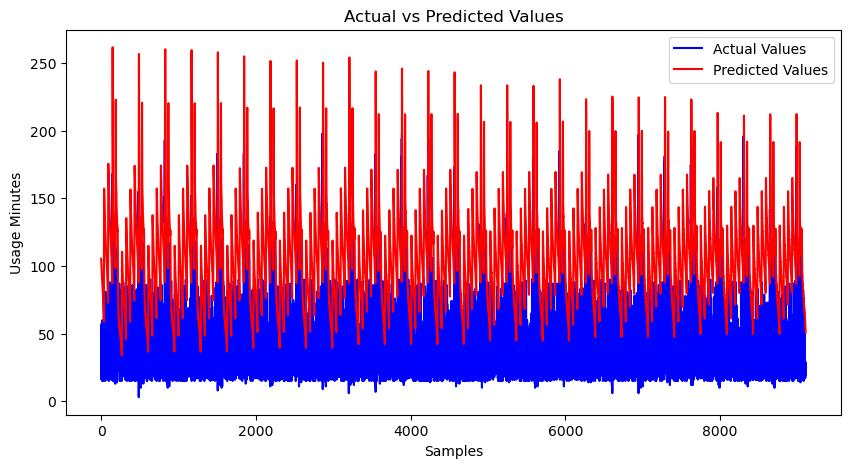

In [21]:
# Generate predictions
predictions = model.predict(X_test)

# Rescale the predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual Values', color='blue')
plt.plot(predictions_rescaled, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Usage Minutes')
plt.legend()
plt.show()


In [22]:
## L2 regularization or dropout to the dense layer and the GRU layers

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(sequence_length, len(features)),
        kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    GRU(32, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1)
])


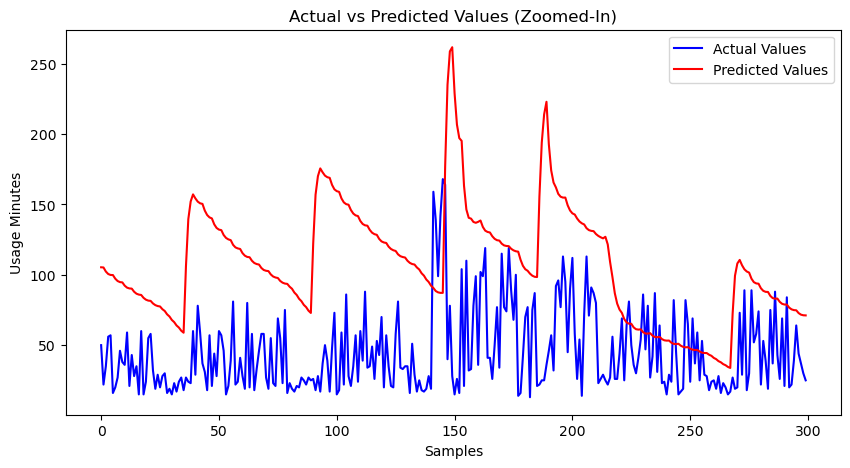

In [23]:
# Visualize Actual vs Predicted Values for a Subset
subset_size = 300  # Choose a smaller subset for better readability
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:subset_size], label='Actual Values', color='blue')
plt.plot(predictions_rescaled[:subset_size], label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values (Zoomed-In)')
plt.xlabel('Samples')
plt.ylabel('Usage Minutes')
plt.legend()
plt.show()


In [24]:
# Rescale the actual and predicted values
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(predictions)


In [ ]:
# Calculate Metrics :- Now that both y_test_rescaled and predictions_rescaled are defined, you can compute the evaluation metrics:

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Absolute Error (MAE): 65.36
Mean Squared Error (MSE): 5575.37
R-squared (R²): -6.50


In [26]:
# Generate predictions
predictions = model.predict(X_test)


285/285 [==============================] - 1s 4ms/step


In [29]:
# Function to predict usage for a specific day
def predict_for_day(model, df, scaler, features, target_column, sequence_length, day):
    # Ensure the day is in datetime format
    day = pd.to_datetime(day)
    
    # Filter the data for the specific day
    daily_data = df[df['timestamp'].dt.date == day.date()]
    
    if len(daily_data) < sequence_length:
        print("Insufficient data for the specified day.")
        return None
    
    # Prepare input sequences for the day
    X_day = []
    for i in range(len(daily_data) - sequence_length):
        X_day.append(daily_data[features].iloc[i:i + sequence_length].values)
    
    X_day = np.array(X_day)
    X_day = X_day.reshape(X_day.shape[0], X_day.shape[1], len(features))
    
    # Generate predictions for the day
    predictions = model.predict(X_day)
    predictions_rescaled = scaler.inverse_transform(predictions)
    
    # Get the actual usage for the day
    actual_values = daily_data[target_column].iloc[sequence_length:].values
    actual_values_rescaled = scaler.inverse_transform(actual_values.reshape(-1, 1))
    
    return actual_values_rescaled, predictions_rescaled

# Example: Predict for a specific day
specific_day = "2023-12-02"  # Replace with the desired day
actual_values, predicted_values = predict_for_day(
    model=model,
    df=df,
    scaler=scaler,
    features=features,
    target_column='normalized_usage_minutes',
    sequence_length=sequence_length,
    day=specific_day
)


1/1 [==============================] - 1s 587ms/step


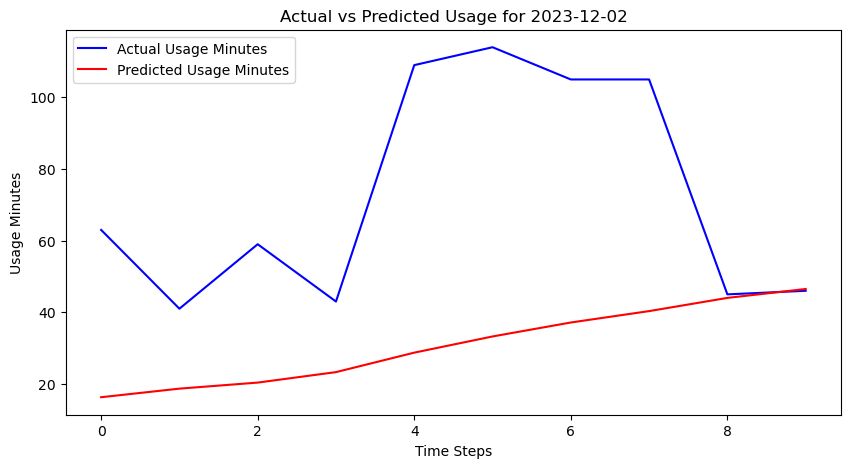

In [30]:

# Visualize Actual vs Predicted for the Specific Day
if actual_values is not None and predicted_values is not None:
    plt.figure(figsize=(10, 5))
    plt.plot(actual_values, label='Actual Usage Minutes', color='blue')
    plt.plot(predicted_values, label='Predicted Usage Minutes', color='red')
    plt.title(f'Actual vs Predicted Usage for {specific_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('Usage Minutes')
    plt.legend()
    plt.show()


In [31]:
import pandas as pd

# Combine actual and predicted values into a DataFrame
def get_results_table(actual_values, predicted_values, timestamp_column):
    results_df = pd.DataFrame({
        'Timestamp': timestamp_column,  # Timestamps for the day
        'Actual Usage Minutes': actual_values.flatten(),
        'Predicted Usage Minutes': predicted_values.flatten()
    })
    return results_df

# Example: Create results table for the specific day
if actual_values is not None and predicted_values is not None:
    # Use timestamps from the original filtered dataset
    timestamps_for_day = df[df['timestamp'].dt.date == pd.to_datetime(specific_day).date()]['timestamp'].iloc[sequence_length:]
    
    # Get the results DataFrame
    results_df = get_results_table(actual_values, predicted_values, timestamps_for_day)

    # Display the results
    print(results_df)

    # Optionally, save to CSV
    results_df.to_csv(f'actual_vs_predicted_{specific_day}.csv', index=False)
    print(f"Results saved to 'actual_vs_predicted_{specific_day}.csv'")


                Timestamp  Actual Usage Minutes  Predicted Usage Minutes
34030 2023-12-02 19:30:00                  63.0                16.285852
34031 2023-12-02 19:45:00                  41.0                18.682850
34032 2023-12-02 22:00:00                  59.0                20.370144
34033 2023-12-02 22:15:00                  43.0                23.295254
34034 2023-12-02 22:30:00                 109.0                28.731300
34035 2023-12-02 22:45:00                 114.0                33.249840
34036 2023-12-02 23:00:00                 105.0                37.147671
34037 2023-12-02 23:15:00                 105.0                40.327572
34038 2023-12-02 23:30:00                  45.0                44.016659
34039 2023-12-02 23:45:00                  46.0                46.501171
Results saved to 'actual_vs_predicted_2023-12-02.csv'
